In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import re
import os
import pickle
import requests
import json
import urllib.request
from fa2 import ForceAtlas2
import community
import math
import nltk
from nltk import word_tokenize
from nltk.book import *
from wordcloud import WordCloud

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [2]:
# create two functions that clean the names and links

def parse_links_from_file(file):
    links = set()
    for link in re.findall('\[\[([^\]]*)\]\]', file):
        if '|' in link:
            link = link.split('|')[0]
        links.add(link)
    return [link.lower() for link in links]

def parse_node(node):
    return node.split(".")[0].replace("_", " ").replace(" dc", "").replace(" marvel", "").lower()

In [3]:
# go through the txt files in os_listdir() and create a node with the name of the file and add an attribute if they are from dc or marvel and open the file and find the hyperlinks in the file and if the hyperlinks has any word that is a node in the graph add an edge between the node and the hyperlinks. if the hyperlinks has a word that is not a node in the graph skip it. If there is an edge already skip it
G = nx.DiGraph()

for i in os.listdir():
    if i.endswith(".txt"):
        with open(i, 'r') as f:
            file = f.read()
            if "dc" in i:
                G.add_node(parse_node(i), type='dc', file=i, words = len(re.findall(r'\w+', file)))
            else:
                G.add_node(parse_node(i), type='marvel', file=i, words = len(re.findall(r'\w+', file)))

In [4]:
edges = {}

for i in G.nodes(data=True):
    with open(i[1]['file'], 'r') as f:
        file = f.read()
        links = parse_links_from_file(file)
        edges[i[0]] = links

for name, edges in edges.items():
    for edge in edges:
        if edge in list(G.nodes):
            G.add_edge(*(name, edge))

In [5]:
#extract the largest component from the graph

G1 = max(nx.weakly_connected_components(G), key=len)

G1 = G.subgraph(G1)

In [6]:
#We need to make the network undirected
G1 = G1.to_undirected()

In [40]:
forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=2.0,

                            # Log
                            verbose=True)


In [8]:
#Computing best partition
comms = community.best_partition(G1) 

In [9]:
#printing the number of communities
comms_values = list(comms.values())

size_communities = float(len(set(comms_values)))
print(size_communities)

7.0


In [52]:
#Computing the modularity
community.modularity(comms, G1)

0.5062855192922995

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.29it/s]


BarnesHut Approximation  took  13.22  seconds
Repulsion forces  took  22.85  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.25  seconds
AdjustSpeedAndApplyForces step  took  0.49  seconds


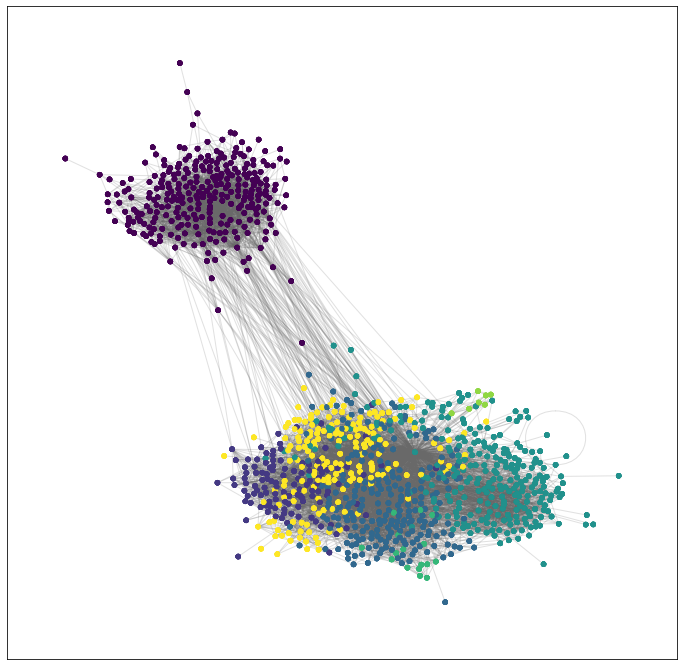

In [50]:
plt.figure(figsize=(12,12))
pos = forceatlas2.forceatlas2_networkx_layout(G1, pos=None, iterations=2000)
count = 0.
cmap = cm.get_cmap('viridis', max(comms.values()) + 1)
for com in set(comms.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in comms.keys()
                                if comms[nodes] == com]
    nx.draw_networkx_nodes(G1, pos, comms.keys(), node_size=20,
                     cmap=cmap, node_color=list(comms.values()))


communities=nx.draw_networkx_edges(G1, pos, alpha=0.2, edge_color="dimgray")

plt.show()

We used the Louvain algorithm to detect communities in the network of both the Marvel and DC universes. It maximizes the modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network.

Ref: https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/#:~:text=The%20Louvain%20method%20is%20an,assignment%20of%20nodes%20to%20communities.

The modularity value is calculated to 0.5062855192922995, which means that the communities are quite well partitioned. This can also be seen in the graph above. The communities are well grouped. 

We see that there is 


We were not able to exstract the communities with the belonging text, so we did the TF-IDF on both universes instead. Sorry for the mistake.

In [17]:
#We open the files and devide them into the different universes. 
with open('full_dc.txt', 'w') as outfile:
    
    for i in os.listdir():
        if i.endswith(".txt"):
            with open(i, 'r') as infile:
                if "dc" in i:
                    outfile.write(infile.read())
        
                outfile.write("\n")

with open('full_marvel.txt', 'w') as outfile:
    
    for i in os.listdir():
        if i.endswith(".txt"):
            with open(i, 'r') as infile:
                if "marvel" in i:
                    outfile.write(infile.read())
        
                outfile.write("\n")

In [18]:
#tokenize the words in each universe. 
raw = open('full_dc.txt').read()
dc_tokens = word_tokenize(raw)

raw = open('full_marvel.txt').read()
marvel_tokens = word_tokenize(raw)

In [20]:
#Put every word in lower case

words_dc = [w.lower() for w in dc_tokens if w.isalpha()]

words_marvel = [w.lower() for w in marvel_tokens if w.isalpha()]

In [21]:
#Removing stopwords
tokens_dc = FreqDist(words_dc)

stopwords = nltk.corpus.stopwords.words('english')
words = [w for w in tokens_dc]
for w in words: 
        if w in stopwords or not w.isalpha():
            tokens_dc.pop(w)
            
tokens_marvel = FreqDist(words_marvel)

stopwords = nltk.corpus.stopwords.words('english')
words = [w for w in tokens_marvel]
for w in words: 
        if w in stopwords or not w.isalpha():
            tokens_marvel.pop(w)

The TF - Term Frequency roughly mean number of terms in a document

In [80]:
def term_f(token_list):
    
    tf={}
    
    for word in token_list:
        if word in tf:
            tf[word] += 1
        else:
            tf[word] = 1
            
    for key in tf.keys():
        tf[key] = tf[key]/len(token_list)
    
    return tf


IDF - Inverse Document Frequency is defined by = log ( Total number of documents / (occurrence term in documents) )

IDF means how rare a term is in the collection of documents

In [96]:
#We are aware that common words can be in both universes. Uncommon words are log(2/1) and Common words are log(2/2)

common_tokens = set(tokens_marvel).intersection(set(tokens_dc))

In [91]:
def inverse_df(token_list, common_tokens_set):
      
    idf={}
    
    for word in token_list:
        if word not in idf:
            if word in common_tokens_set:
                idf[word] =  math.log(2/2)
            else:
                idf[word] =  math.log(2/1)    
    
    return idf

The TF-IDF roughly means that a term is weighted in how relevant it is to the document. The TF-IDF multiplies both TF and IDF to give the words a score on the relevance. 

In [92]:
def tfidf(token_list, common_tokens_set):
    
    tfidf = {}
    
    tf = term_f(token_list)
    idf = inverse_df(token_list, common_tokens_set)
    
    for key, value in tf.items():
        tfidf[key] = value*idf[key]
    
    return tfidf

In [93]:
marvel_tfidf = tfidf(tokens_marvel, common_tokens)
dc_tfidf = tfidf(tokens_dc, common_tokens)

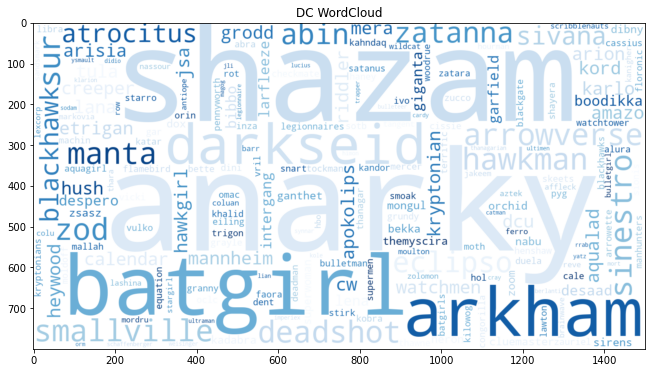

In [94]:
plt.figure(figsize=(12,6))
dc_wc = WordCloud(background_color="white", width=1500, height=800, 
                     colormap = 'Blues')
dc_wc.generate_from_frequencies(dc_tfidf)

plt.imshow(dc_wc, interpolation="bilinear")
plt.title('DC WordCloud')
plt.show()

We can see that Anarky and Shazam are very important in the DC universe according to our wordcloud. However, this do not help us understand the universe that well. As fans of both DC and Marvel, we were quite surprised by the result.  

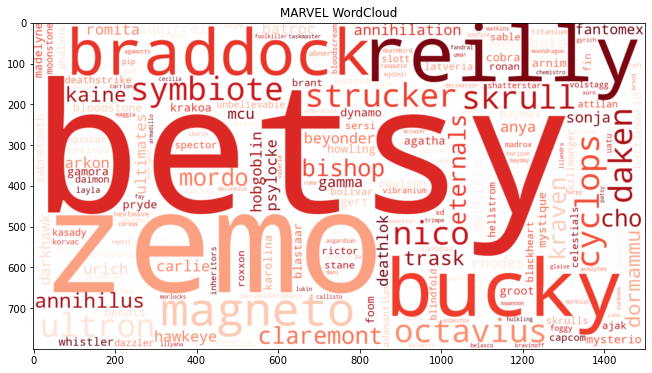

In [95]:
plt.figure(figsize=(12,6))
marvel_wc = WordCloud(background_color="white", width=1500, height=800, 
                     colormap = 'Reds')
marvel_wc.generate_from_frequencies(marvel_tfidf)

plt.imshow(marvel_wc, interpolation="bilinear")
plt.title('MARVEL WordCloud')
plt.show()

We that Betsy, Zemo and Bucky are very relevant. However, this is the same case as for DC. As fans this do not help us understand the universe better.

This is also a bad side of the TF-IDF as it doesnt weight the words in a semantic way and evaluate the words in that sense.